In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nba_api.stats.static import teams
from nba_api.stats.endpoints import shotchartdetail
nba_teams = teams.get_teams()

In [2]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
steph = players.find_players_by_full_name('stephen curry')[0]
steph_info = commonplayerinfo.CommonPlayerInfo(player_id=steph['id'])

In [3]:
# Credit: savvastjortjoglou
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
currentSeason = steph_info.get_normalized_dict()['AvailableSeasons'][-1]

In [5]:
steph_array = np.array(shotchartdetail.ShotChartDetail(player_id=steph['id'],
                                                       team_id=0,
                                                       month=0,
                                                       context_measure_simple="FGA",
                                                       season_nullable='2018-19')
                       .get_normalized_dict()['Shot_Chart_Detail'])

In [6]:
print(len(steph_array))
print(steph_array[250])

1270
{'GRID_TYPE': 'Shot Chart Detail', 'GAME_ID': '0021800331', 'GAME_EVENT_ID': 533, 'PLAYER_ID': 201939, 'PLAYER_NAME': 'Stephen Curry', 'TEAM_ID': 1610612744, 'TEAM_NAME': 'Golden State Warriors', 'PERIOD': 4, 'MINUTES_REMAINING': 9, 'SECONDS_REMAINING': 44, 'EVENT_TYPE': 'Made Shot', 'ACTION_TYPE': 'Cutting Layup Shot', 'SHOT_TYPE': '2PT Field Goal', 'SHOT_ZONE_BASIC': 'Restricted Area', 'SHOT_ZONE_AREA': 'Center(C)', 'SHOT_ZONE_RANGE': 'Less Than 8 ft.', 'SHOT_DISTANCE': 1, 'LOC_X': 9, 'LOC_Y': 17, 'SHOT_ATTEMPTED_FLAG': 1, 'SHOT_MADE_FLAG': 1, 'GAME_DATE': '20181201', 'HTM': 'DET', 'VTM': 'GSW'}


In [7]:
madeShotMask = np.array([item['SHOT_MADE_FLAG'] == 1 for item in steph_array])

madeShots = steph_array[madeShotMask]
missedShots = steph_array[~madeShotMask]

In [8]:
madeX_shotLocations = [shot['LOC_X'] for shot in madeShots]
madeY_shotLocations = [shot['LOC_Y'] for shot in madeShots]

missX_shotLocations = [shot['LOC_X'] for shot in missedShots]
missY_shotLocations = [shot['LOC_Y'] for shot in missedShots]

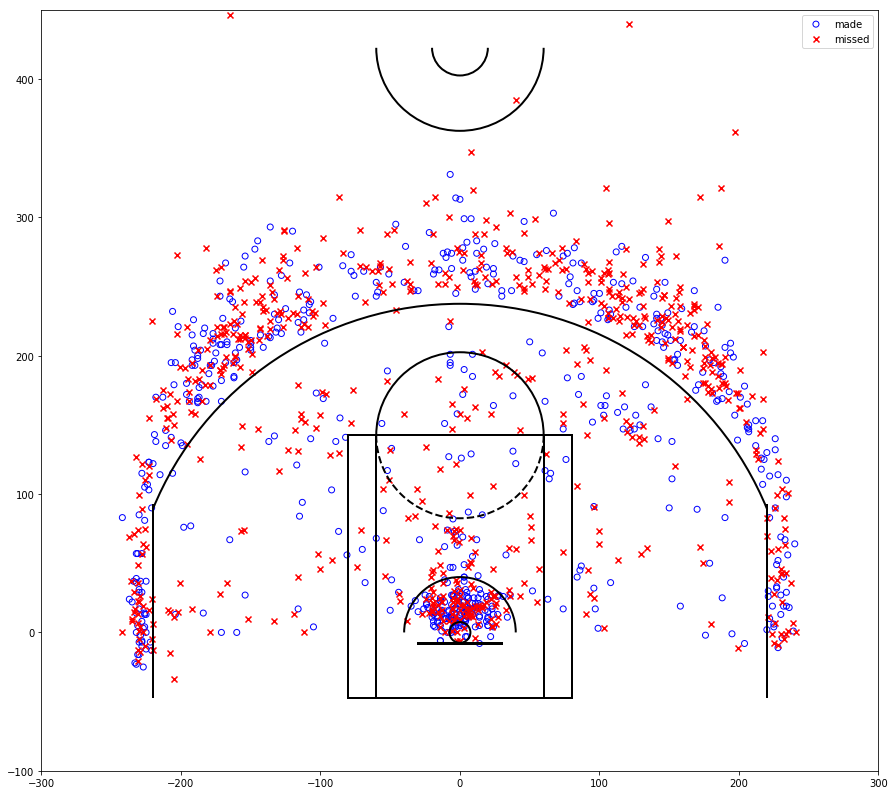

In [9]:
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(111)
draw_court(ax)

ax.scatter(madeX_shotLocations,madeY_shotLocations,label="made", facecolors='none', edgecolors='b')
ax.scatter(missX_shotLocations,missY_shotLocations,color="r",label="missed", marker="x")
ax.legend()


plt.xlim(-300,300)
plt.ylim(-100,450)
plt.show()

In [10]:
from scipy.stats import gaussian_kde

In [17]:
def density_helper(x,y):
    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return (xi,yi,zi)

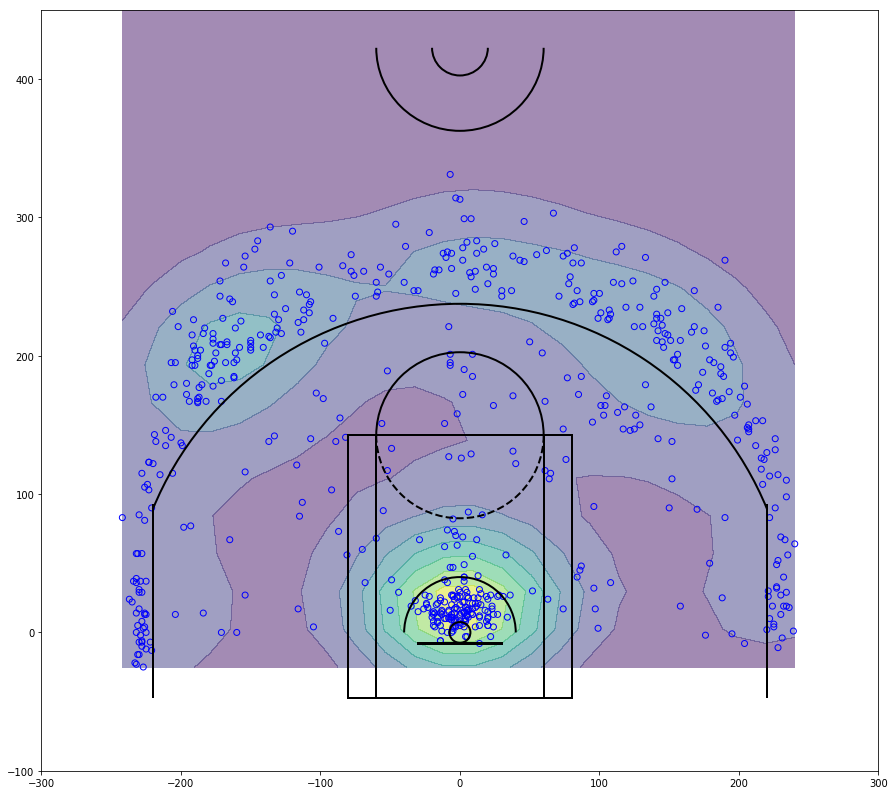

In [26]:
# Calculate the point density
madeX_shotLocations = np.array(madeX_shotLocations)
madeY_shotLocations = np.array(madeY_shotLocations)
xy = np.vstack([madeX_shotLocations,madeY_shotLocations])
z = gaussian_kde(xy)(xy)

xi,yi,zi = density_helper(madeX_shotLocations, madeY_shotLocations)

fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(111)

#ax.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.9)
ax.contourf(xi, yi, zi.reshape(xi.shape), alpha=0.5)


ax.set_xlim(madeX_shotLocations.min(), madeX_shotLocations.max())
ax.set_ylim(madeY_shotLocations.min(), madeY_shotLocations.max())


draw_court(ax)
ax.scatter(madeX_shotLocations,madeY_shotLocations,label="made", facecolors='none', edgecolors='b')

plt.xlim(-300,300)
plt.ylim(-100,450)
plt.show()